In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
from keras.models import load_model
from keras.utils import to_categorical
from keras import backend as K
import seaborn as sns
from keras.applications.vgg16 import VGG16

Including 30 3D-groups of CTimages, which are sliced, in a train_generator and 30 images in val_generator <br/>
Defining Directories, color mode, image sizes and other specifications

In [2]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
        '/home/kenan/Desktop/COV19D/train/', 
        color_mode = "grayscale",
        target_size=(128, 128),  # All images are 512 * 512
        batch_size=batch_size,
        classes = ['covid','non-covid'],
        class_mode='binary')

Found 15213 images belonging to 2 classes.


(32, 128, 128, 1)
(128, 128, 1)


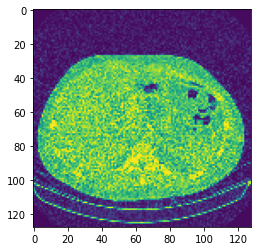

In [3]:
# Displaying an image in the train_generator
batch=next(train_generator) 
print(batch[0].shape) 
img=batch[0][0] # The first image in the train_generator
print (img.shape)
plt.imshow(img)

In [4]:
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        '/home/kenan/Desktop/COV19D/validation/', 
        color_mode = "grayscale",
        target_size=(128, 128),  
        batch_size=batch_size,
        classes = ['covid','non-covid'],
        class_mode='binary')

Found 15598 images belonging to 2 classes.


In [7]:
y_train = train_generator.classes
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [8]:
y_val = val_generator.classes 
y_val

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [9]:
SIZE = 128
#Loading the VGG16 model wothout a classifier, fully connected layers
VGG_model = VGG16(include_top=False, weights=None, input_shape=(SIZE, SIZE, 1))
#Making loaded layers non-trainable.
for layer in VGG_model.layers:
	layer.trainable = False
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [10]:
#N Ectracting features from the convolutional network for the classifier
feature_extractor=VGG_model.predict(train_generator)

In [11]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [12]:
#importing the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [13]:
# Training the classifier on the ectracted training features
RF_model.fit(features, y_train) 

RandomForestClassifier(n_estimators=50, random_state=42)

In [14]:
# Feature exctracting in the validation data using the same VGG16 model
X_val_feature = VGG_model.predict(val_generator)
X_val_features = X_val_feature.reshape(X_val_feature.shape[0], -1)

In [15]:
#Predicting using validation features through the transfered model
prediction_RF = RF_model.predict(X_val_features)

In [16]:
##### Checking the overall accuracy and Macro f1 Score of the classifier #########
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_val, prediction_RF))
print ("Macro f1_score = ", metrics.f1_score(y_val, prediction_RF))

Accuracy =  0.508206180279523
Macro f1_score =  0.5717157054324158


<AxesSubplot:>

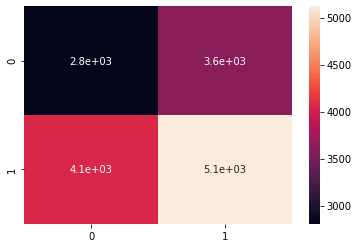

In [17]:
# The confusion metrics of the classifier
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

(32, 128, 128, 1)
(128, 128, 1)
The prediction for this image is:  0
The actual label for this image is:  0


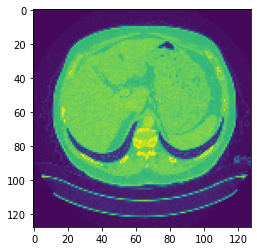

In [19]:
# Showing class prediction on one image in the val_generator
batch=next(train_generator) 
print(batch[0].shape)
img=batch[0][0] 
print (img.shape)
plt.imshow(img)

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", y_train[0])